In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
 
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
 
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
 
from tensorflow import keras
 
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model
from keras.layers import Flatten
from tensorflow.keras.layers.experimental import preprocessing
 
import tensorflow as tf
import tensorflow_addons as tfa
from keras import regularizers
from keras import backend as K

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

print(tf.__version__)

Using TensorFlow backend.
2.1.0


# The well drilling dataset

The dataset was collected from 7 wells in Hassi Messaoud Oil Field

the drilling parametrs used in this study are: DEPTH, WOB , WOH , TORQUE, RPM, FLOW IN PUMPS, SPP, ROP 

In [19]:
rop = "ROP_inst_cal"
 
target = ['For','Depth','WOH Max','WOH Avg','WOB Max','WOB Avg','Torque Max',
          'Torque Avg', 'Torque Min', 'Pressure: SPP Avg',
          'RPM Avg', 'Flow In Pumps Avg', 
          'ROP_inst_cal'
        ]

dataset = pd.read_csv('well_11_60.csv',na_values=[0,-9999.99])
dataset['Depth'] = dataset['Depth: TMD']
dataset.pop('Depth: TMD')
dataset = dataset[dataset['Flow In Pumps Avg']<50000]
dataset = dataset[target]

## Clean the data

The dataset contains a few unknown values.

In [20]:
dataset.isna().sum()
dataset = dataset.dropna()

## The correlation between the parameters

visualize the correlation between the parameters

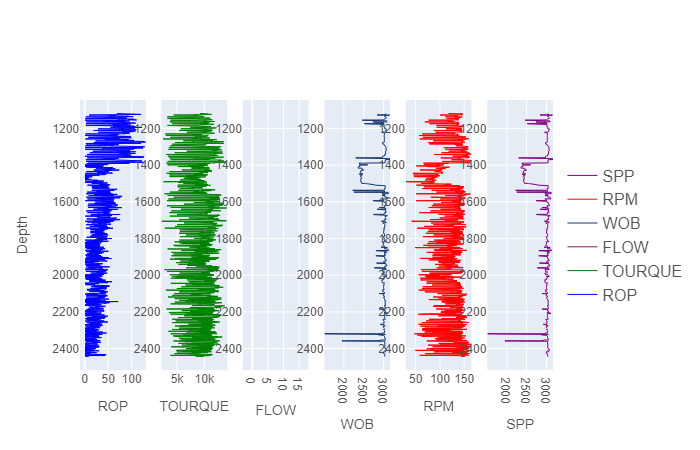

In [4]:
log = [dataset.ROP_inst_cal, dataset[ 'Torque Avg'],  dataset['WOH Avg'], dataset['Flow In Pumps Avg'], dataset['RPM Avg'], dataset['Pressure: SPP Avg']]

labels = ['ROP', 'TOURQUE', 'FLOW', 'WOB', 'RPM', 'SPP']

colors = ['blue', 'green', '#851e52', '#16356d',
            'red', 'purple', 'black',
            '#16356d', '#f79b32', '#525252']

fig = make_subplots( cols=6)
for i in range(0, 6):
        fig.add_trace(go.Scatter(x=log[i], y=dataset.Depth, mode='lines',
                                    name=labels[i],
                                    line=dict(color=colors[i], width=1)), row=1, col=i + 1)
        fig.update_xaxes(title_text=labels[i], col= i+1)
        fig.update_yaxes(autorange='reversed', col=i+1)

        
fig.update_xaxes(title_text=labels[0], range=[-10, 130], col= 1)
fig.update_xaxes(title_text=labels[2], range=[-3, 18], col= 3)

fnt = dict(
        family='Helvetica',
        size=12,
        color='rgb(82, 82, 82)')

fig.update_layout(
    xaxis=dict(
        title='ROP',
        tickfont=fnt,
    ),
    yaxis=dict(
        autorange='reversed',
        title='Depth',
        tickfont=fnt,
    ),
    width=1400,
    height=800,
    font=fnt,
    hovermode="closest",
    legend=dict(y=0.5, traceorder='reversed', font_size=16)
)


fig.show('png')

## the impact of RPM over ROP

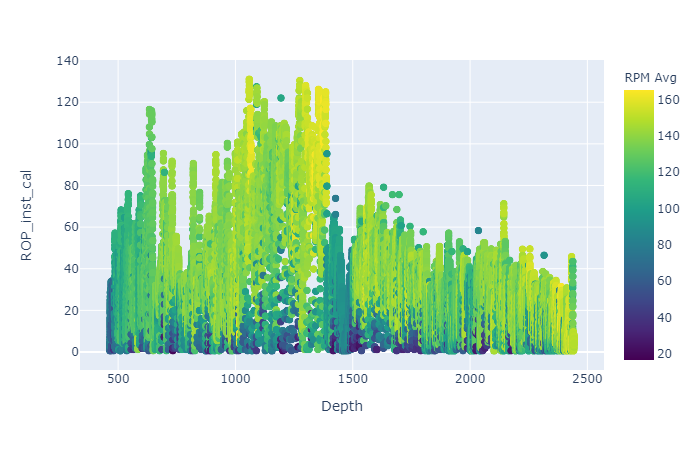

In [6]:
df = px.data.tips()
fig = px.scatter(dataset, x="Depth", y= rop, color="RPM Avg",width=1300, 
           color_continuous_scale=px.colors.sequential.Viridis, render_mode="webgl")
fig.show('png')

## Data Preparation
* The dataset contains many aberrants values that needs to be cleaned out before passed to the machine learning model
* In this part we tried to reduce the noise from the data 



* To ensures that data are less noisy and trends well preserved we are going to considered any data point greater than 3 standard deviations
from the mean as to be an outlier. 

In [7]:
def standard_deviation(x,d):
      return  (x - d['mean']) / d['std']

def std_div_f(dts):
  tranpos = dts.describe().transpose()
  standard_deviation = standard_deviation(dts,tranpos)
  rop_norma = standard_deviation['ROP_inst_cal']
  val_to_remove = norma[ (rop_norma < -3.0) | (rop_norma > 3.0)].index
  dts = dts.drop(val_to_remove)
  return dts

## Abrupt change
I cerated this outlier detection algorithm to remove the abrupt changes whithin the flowed rows

In [14]:
def abruptChange(dataset):
    ls = ['Pressure: SPP Avg','Torque Avg', 'RPM Avg','Flow In Pumps Avg', 'WOB Avg']

    dataset.sort_values(ls, inplace=True)
    que = []
    queTMP = []
    old = dataset['ROP_inst_cal'].values[0]
    boolean = False
    j = 0
 
    for index, row in dataset.iterrows():
      new = row['ROP_inst_cal']
      cond = abs(old - new) > 9.0
      if boolean == True:
        if j > 5:
          queTMP = []
          boolean = False
          j = 0
        elif cond:
          queTMP.append(index)
          que = queTMP + que
          queTMP = []
          j = 0
          boolean = False
        else:
          queTMP.append(index)
          j += 1
      elif cond:
        queTMP.append(index) 
        boolean = True
      old = new
    dataset.drop(que, inplace=True)

## butterworth filter
butterworth filter used to remove the noise from RPM signal

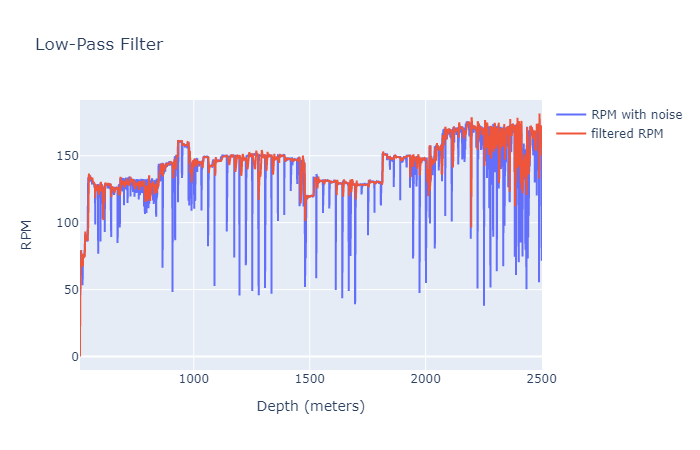

In [40]:
from scipy.signal import butter, lfilter, freqz


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def low_pass(dataset, featur = 'WOB Avg'):
  # Filter requirements.
  order = 6
  fs = 24.88      # sample rate, Hz
  j  = 0 
  delta_t = dataset.Depth.values[1] - dataset.Depth.values[0]
  while delta_t == 0:
    j += 1
    delta_t = dataset.Depth.values[j + 1] - dataset.Depth.values[j] 
  n = 40
  cutoff = 1/(n*delta_t)  # desired cutoff frequency of the filter, Hz
  cutoff = cutoff/(fs/2) #normaliza

  # Get the filter coefficients so we can check its frequency response.
  b, a = butter_lowpass(cutoff, fs, order)

  data = dataset[featur]
  # Filter the data, and plot both the original and filtered signals.
  y = butter_lowpass_filter(data, cutoff, fs, order)
  dataset[featur] = y
  return y

featur = 'RPM Avg'
y = low_pass(dataset.copy(),featur)
t = dataset.Depth
fig = go.Figure()
fig.add_trace(go.Scatter(
            x = t,
            y = dataset[featur],
            mode='lines',
            marker=dict(
                colorscale='Viridis',
            ),
            name = 'RPM with noise'
            ))
fig.add_trace(go.Scatter(
            x = t,
            y = y,
            mode='lines',
            name = 'filtered RPM'
            ))

fig.update_layout(
    xaxis=dict(title='Depth (meters)'),
    yaxis=dict(title='RPM'),
    title='Low-Pass Filter',
    showlegend=True,
    width=1000,
    height=500,
)

fig.show('png')

# Machine learning model
`adam` optimizer wish have a better performance is used to calculate the gradient decet. 

`l2 regularizer` to add some noise to the model in order to reduce the overfitting.

`activativaion functions` for regression relu / elu / selu / leakyRleu.

`initialization` of weight and biases there are several algorithms such as he_normal...

`epoch`  we'll use an *EarlyStopping callback* that tests a training condition for  every epoch. automatically stop training when the validation score doesn't improve.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.

## Normalize the data
mean and standard deviation defined as folow



<img src="img/norma.png" />

`[a,b]` interval so we chose `[-1,1]`

## Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our models.

In [24]:
wells = [1,2,7,9,10,11,13,14]
estimator = None

rop = "ROP_inst_cal"
 

target = ['For','Depth','WOH Max','WOH Avg','WOB Max','WOB Avg','Torque Max',
          'Torque Avg', 'Torque Min', 'Pressure: SPP Avg',
          'RPM Avg', 'Flow In Pumps Avg', 
          'ROP_inst_cal'
        ]


def mean_absolute_percentage_error(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_data(well_t = [2,13],j=0,outlier=False):
        w = []
        for i in well_t:
          w.extend([pd.read_csv('well_2_60.csv',na_values=[0,-9999.99])])
        dataset = pd.concat(w)
        dataset = dataset[dataset.For != 1]
        dataset = dataset[dataset.For != 2]
        dataset = dataset[dataset.For != 3]
        dataset = dataset[dataset.For != 4]
        dataset['Depth'] = dataset['Depth: TMD']
        dataset.pop('Depth: TMD')
        dataset = dataset[target]
        dataset.isna().sum()
        dataset = dataset.dropna()
        return dataset

def get_acc(i,j=0,outlier=False):
  data = get_data([i],j,outlier)
  true_rop = data.pop(rop)
  pred_7 = model.predict(data).flatten()
  print("well ",i," accuracy: %.2f%%" % (r2_score(true_rop,pred_7)*100)," / %.2f%%" % mean_absolute_percentage_error(true_rop,pred_7))
  return true_rop, pred_7, data

def plot_loss(history):
  plt.rcParams["figure.figsize"] = (10,5)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel("Nombre d'itération ")
  plt.ylabel('Error MSE [ROP]')
  plt.legend()
  plt.grid(True)

def plot_result(test_labels, test_predictions):
  a = plt.axes(aspect='equal')
  plt.rcParams["figure.figsize"] = (10,10)
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values [ROP]')
  plt.ylabel('Predictions [ROP]')
  lims = [-20, 150]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)


def build_model(lenth,hidden,layer,data_len):
    init = 'lecun_normal' #tf.keras.initializers.GlorotNormal()
    activation = 'sigmoid'

    sequence = [Dense(hidden,
                             activation= activation,
                             kernel_initializer=init, 
                             input_shape=(lenth,)
                             )
                ]

    for _ in range(layer-1):
        sequence.append(Dense(hidden, activation= activation, kernel_initializer=init)),

    sequence.append(Dense(1, activation='softplus'))
    model = Sequential(sequence)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=[mape,'mse'])
    return model


def ml(hidden=18,layer=1,well=[7],formation=0):
    ds = dataset.copy()   

    trained_dataset = ds.sample(frac=0.8,random_state=31) # shufled  
    droped = ds.drop(trained_dataset.index)
    valid_dataset = droped.sample(frac=0.5,random_state=31) 
    test_dataset = droped.drop(valid_dataset.index)

    train_stats = trained_dataset.describe()
    train_stats.pop('ROP_inst_cal')
    train_stats = train_stats.transpose()

    Y_train_rop = trained_dataset.pop('ROP_inst_cal')
    Y_test_rop = test_dataset.pop('ROP_inst_cal')
    Y_valid_rop = valid_dataset.pop('ROP_inst_cal')

    
    X_train_auto = standard_deviation(trained_dataset,train_stats)
    X_test_auto = standard_deviation(test_dataset,train_stats)
    X_valid_auto = standard_deviation(valid_dataset,train_stats)
    
    model = build_model(len(X_train_auto.keys()),hidden,layer,len(X_train_auto))

    EPOCHS = 1200
    # The patience parameter is the amount of epochs to check for improvement
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    history = model.fit(X_train_auto, Y_train_rop,
                        epochs=EPOCHS, validation_data=(X_valid_auto, Y_valid_rop) , verbose=0,
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
   
    rop_predictions = model.predict(X_test_auto).flatten()

    from sklearn.metrics import r2_score
    print(formation,"\n accuracy: %.2f%%" % (r2_score(Y_test_rop, rop_predictions)*100))
    return Y_test_rop,rop_predictions,history,model,train_stats



## Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our models.

In [25]:
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.5, nesterov=False)
mape = tf.keras.losses.MeanAbsolutePercentageError()

ro,pr,history,model,std_div  = ml(hidden = 31, layer = 3, well = [2], formation = 0)


Epoch: 0, loss:398.0653,  mean_absolute_percentage_error:211.3645,  mse:398.0655,  val_loss:390.3869,  val_mean_absolute_percentage_error:237.9376,  val_mse:390.3868,  
....................................................................................................
Epoch: 100, loss:34.6855,  mean_absolute_percentage_error:42.5453,  mse:34.6855,  val_loss:36.5029,  val_mean_absolute_percentage_error:41.1682,  val_mse:36.5029,  
....................................................................................................
Epoch: 200, loss:31.8152,  mean_absolute_percentage_error:41.0474,  mse:31.8152,  val_loss:34.1059,  val_mean_absolute_percentage_error:39.9296,  val_mse:34.1059,  
...................................................0 
 accuracy: 91.83%


Text(0, 0.5, 'MSE')

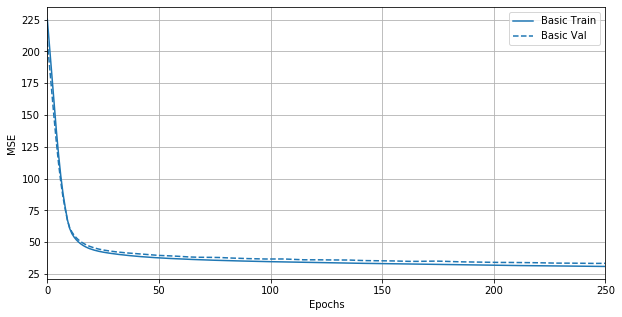

In [26]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = 'mse')
plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel('MSE')

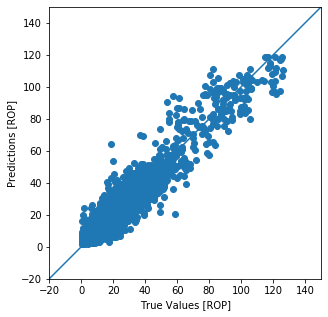

In [27]:
plot_result(ro, pr)